<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="float:right; max-width: 250px; display: inline"  alt="Wikistat"/></a>
</center>

# [Scénarios d'Apprentissage Statistique](https://github.com/wikistat/Apprentissage)

#  Adaptation Statistique d'un Modèle de Prévision du Pic d'Ozone avec <a href="https://cran.r-project.org/"><img src="https://cran.r-project.org/Rlogo.svg" style="max-width: 40px; display: inline" alt="R"/></a>

**Résumé**: Exploration puis modélisation de données climatiques en utilisant R. L'objectif est de prévoir pour le lendemain un possible dépassement d'un seuil de concentration en ozone à partir d'une prévision déterministe sur un maillage grossier et de variables climatiques locales. Estimation par différentes méthodes: régression [linéaire](http://wikistat.fr/pdf/st-m-app-select.pdf) ou   [logistique](http://wikistat.fr/pdf/st-m-app-rlogit.pdf), [analyse discriminante](http://wikistat.fr/pdf/st-m-app-add.pdf), [arbre de décision](http://wikistat.fr/pdf/st-m-app-cart.pdf), [réseau de neurones](http://wikistat.fr/pdf/st-m-app-rn.pdf), [agrégation de modèle](http://wikistat.fr/pdf/st-m-app-agreg.pdf), [SVM](http://wikistat.fr/pdf/st-m-app-svm.pdf). Comparaison des [erreurs de prévision](http://wikistat.fr/pdf/st-m-app-risque-estim.pdf) sur un échantillon test puis des courbes ROC. Industrialisaiton avec le package `caret` et itération sur plusieurs échantillons tests pour analyser la distribution de l'erreur de prévision.

**Avertissement** Il s'agit d'une adaptation du tutoriel que vous trouverez sur wikistat, qui se focalise sur les arbres et forêts aléatoires. Réfléchir aux réponses aux questions marquées **Q** issues du sujet d'examen.

## Introduction

L'objectif, sur ces données, est d'améliorer la prévision déterministe (MOCAGE), calculée par les services de MétéoFrance,  de la concentration d'ozone dans certaines stations de prélèvement.  Il s'agit d'un problème dit d'*adaptation statistique* d'une prévision locale de modèles à trop grande échelle en s'aidant d'autres variables également gérées par MétéoFrance, mais à plus petite échelle (température, force du vent...). C'est une première façon de concevoir de l'l'*IA hybride* entre un modèle déterministe et un algorithme d'apprentissage automatique. Plus précisément, deux variables peuvent être prévues : soit la concentration quantitative d'ozone, soit le dépassement (qualitatif) d'un certain seuil fixé à 150 $\mu g$. Dans chaque cas, deux approches sont considérées : soit prévoir la *concentration quantitative* puis en déduire l'éventuel dépassement ou bien prévoir directement le *dépassement*. Dans le premier cas, il s'agit d'abord d'une *régression* tandis que dans le deuxième il s'agit d'un problème de *discrimination* à deux classes ou de régression logistique. 

La question posée est donc: quelles sont les meilleures méthodes et stratégies pour prévoir la concentration d'ozone du lendemain d'une part et l'occurrence d'un pic de pollution d'autre part.

On se propose de tester ici uniquement : [arbre de décision](http://wikistat.fr/pdf/st-m-app-cart.pdf), [agrégation d'arbres](http://wikistat.fr/pdf/st-m-app-agreg.pdf) (bagging, boosting, random forest).  
Voir le notebook du même nom sur wikistat pour une comparaison beaucoup plus complète.
L'objectif final, à ne pas perdre de vue, est la comparaison de ces méthodes afin de déterminer la plus efficace pour répondre au problème de prévision. Ceci passe par la mise en place d'un protocole très strict afin de s'assurer d'un minimum d'objectivité pour cette comparaison.

Toutes les opérations sont réalisées dans R avec l'appui de bibliothèques complémentaires éventuellement à télécharger (`ROCR, mlbench, MASS, boot, class, e1071, rpart, partykit, nnet, ipred, gbm, randomForest, caret`). Python (consulter le [calepin](https://github.com/wikistat/Apprentissage/blob/master/Pic-ozone/Apprent-Python-Ozone.ipynb)) conduit à des résultats comparables mais moins complets pour leur interprétation. En particulier, l'absence du type *DataFrame* dans la librairie scikit-learn n'autorise pas une sélection fine des variables dans les modèles statistiques usuels. En revanche, l'exécution de la validation croisée Monte Carlo est plus rapide en python

## Prise en charge des données

Les données ont été extraites et mises en forme par le service concerné de Météo France. Elles sont décrites par les variables suivantes:


* **JOUR** Le type de jour ; férié (1) ou pas (0) ;
* **O3obs** La concentration d'ozone effectivement observée le lendemain à 17h locales correspondant souvent au maximum de pollution observée ;
* **MOCAGE** Prévision de cette pollution obtenue par un modèle déterministe de mécanique des fluides (équation de Navier et Stockes);
* **TEMPE** Température prévue par MétéoFrance pour le lendemain 17h ;
* **RMH2O** Rapport d'humidité ;
* **NO2** Concentration en dioxyde d'azote ;
* **NO** Concentration en monoxyde d'azote ;
* **STATION** Lieu de l'observation : Aix-en-Provence, Rambouillet, Munchhausen, Cadarache et Plan de Cuques ;
* **VentMOD** Force du vent ;
* **VentANG** Orientation du vent. 

Ce sont des données "propres", sans trous, bien codées et de petites tailles. Elles présentent donc avant tout un caractère pédagogique car permettant de décliner puis comparer toutes les approches de régression et classification supervisée.

**Attention**: Même si les données sont de qualité, une étude exploratoire préalable est toujours nécessaire pour se familiariser avec les données et les préparer à la phase de modélisation.

In [21]:
# Lecture des données
# path="http://www.math.univ-toulouse.fr/~besse/Wikistat/data/"
path <- ""
ozone <- read.table(paste(path, "depSeuil.dat", sep = ""), 
                                            sep = ",", header = T)
# Vérification du contenu
summary(ozone)

      JOUR            O3obs           MOCAGE          TEMPE      
 Min.   :0.0000   Min.   : 19.0   Min.   : 46.4   Min.   :10.40  
 1st Qu.:0.0000   1st Qu.: 87.0   1st Qu.: 97.5   1st Qu.:20.20  
 Median :0.0000   Median :109.0   Median :125.6   Median :23.80  
 Mean   :0.3045   Mean   :115.4   Mean   :127.2   Mean   :23.88  
 3rd Qu.:1.0000   3rd Qu.:135.0   3rd Qu.:153.6   3rd Qu.:27.60  
 Max.   :1.0000   Max.   :319.0   Max.   :284.7   Max.   :38.00  
     RMH2O              NO2               NO           STATION         
 Min.   :0.00285   Min.   : 0.258   Min.   :0.0010   Length:1041       
 1st Qu.:0.00763   1st Qu.: 1.248   1st Qu.:0.2360   Class :character  
 Median :0.00985   Median : 2.109   Median :0.3880   Mode  :character  
 Mean   :0.01025   Mean   : 3.505   Mean   :0.6574                     
 3rd Qu.:0.01244   3rd Qu.: 4.062   3rd Qu.:0.7440                     
 Max.   :0.02753   Max.   :44.396   Max.   :9.4290                     
    VentMOD           VentANG     

In [22]:
# Changement du type de la variable jour en facteur
ozone[, "JOUR"] <- as.factor(ozone[, "JOUR"])
ozone[, "O3obs"] <- as.numeric(ozone[, "O3obs"])

## 1. Exploration élémentaire

Remarquer le type des variables. Il est nécessaire d'en étudier la distribution. Noter la symétrie ou non de celles-ci.

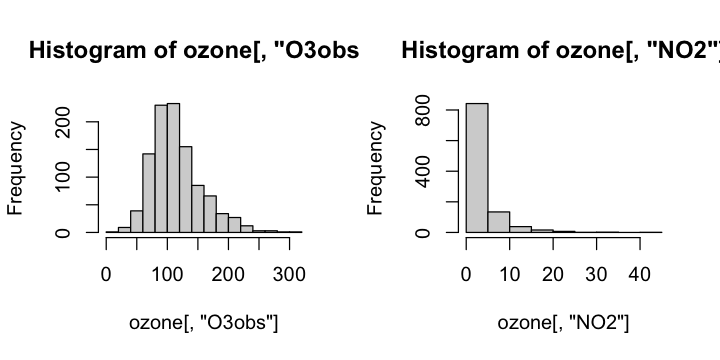

In [23]:
par(mfrow=c(1,2))
options(repr.plot.width=6, repr.plot.height=3)
hist(ozone[,"O3obs"])
hist(ozone[,"NO2"])

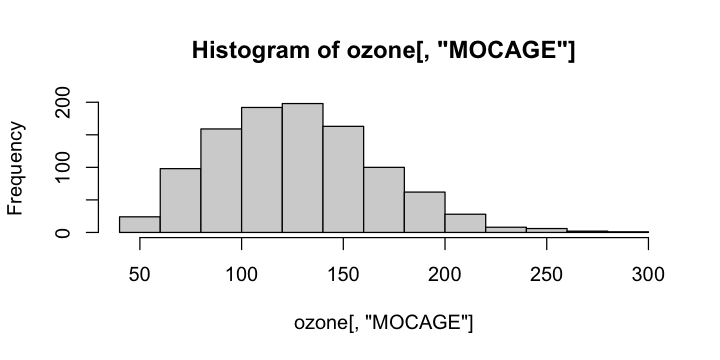

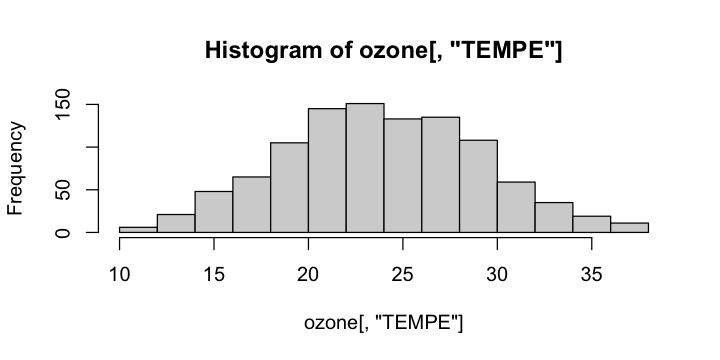

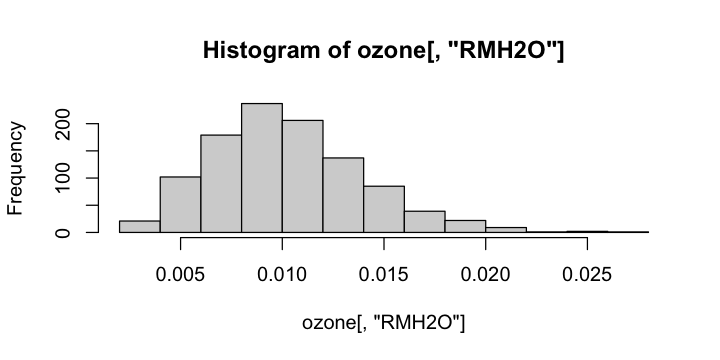

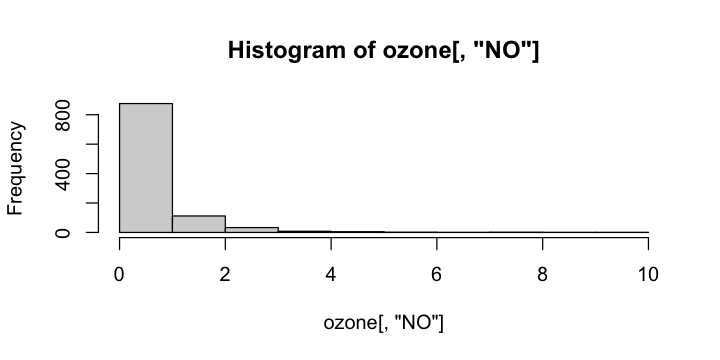

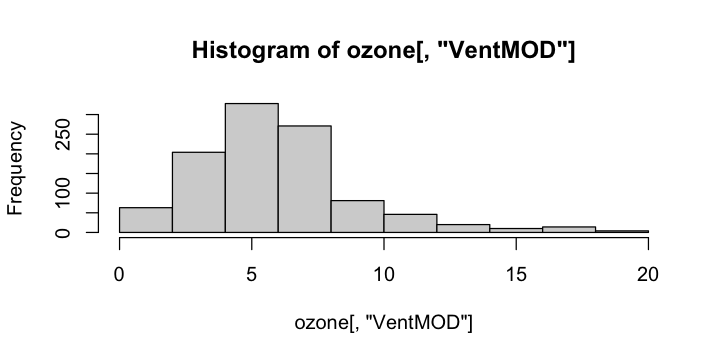

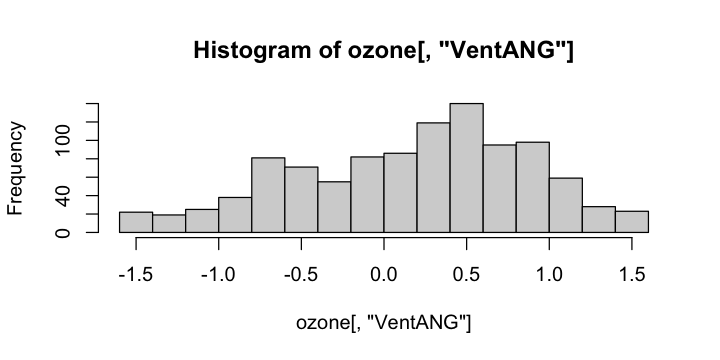

In [24]:
# Même chose pour les autres variables
hist(ozone[,"MOCAGE"]);hist(ozone[,"TEMPE"]);hist(ozone[,"RMH2O"])
hist(ozone[,"NO"]);hist(ozone[,"VentMOD"]);hist(ozone[,"VentANG"])

Des transformations sont proposées pour rendre certaines distributions plus symétriques et ainsi plus "gaussiennes". C'est nécessaire pour certaines méthodes à venir de modélisation (linéaires), par pour toutes (arbres).

In [25]:
ozone[,"SRMH2O"]=sqrt(ozone[,"RMH2O"])
ozone[,"LNO2"]=log(ozone[,"NO2"])
ozone[,"LNO"]=log(ozone[,"NO"])

# Chercher les transform pour avoir du Gausienne
# Objectif numérique !

Vérifier l'opportunité de ces transformations puis retirer les variables initiales et construire la variable "dépassement de seuil" pour obtenir le fichier qui sera effectivement utilisé.


In [26]:
ozone=ozone[,c(1:4,8:13)]
ozone[,"DepSeuil"]=as.factor(ozone[,"O3obs"]>150)
summary(ozone)

 JOUR        O3obs           MOCAGE          TEMPE         STATION         
 0:724   Min.   : 19.0   Min.   : 46.4   Min.   :10.40   Length:1041       
 1:317   1st Qu.: 87.0   1st Qu.: 97.5   1st Qu.:20.20   Class :character  
         Median :109.0   Median :125.6   Median :23.80   Mode  :character  
         Mean   :115.4   Mean   :127.2   Mean   :23.88                     
         3rd Qu.:135.0   3rd Qu.:153.6   3rd Qu.:27.60                     
         Max.   :319.0   Max.   :284.7   Max.   :38.00                     
    VentMOD           VentANG            SRMH2O             LNO2        
 Min.   : 0.1414   Min.   :-1.5708   Min.   :0.05339   Min.   :-1.3548  
 1st Qu.: 3.9623   1st Qu.:-0.3948   1st Qu.:0.08735   1st Qu.: 0.2215  
 Median : 5.5973   Median : 0.2783   Median :0.09925   Median : 0.7462  
 Mean   : 5.9072   Mean   : 0.1631   Mean   :0.09957   Mean   : 0.8440  
 3rd Qu.: 7.1063   3rd Qu.: 0.6926   3rd Qu.:0.11153   3rd Qu.: 1.4017  
 Max.   :19.8910   Max.   : 1.

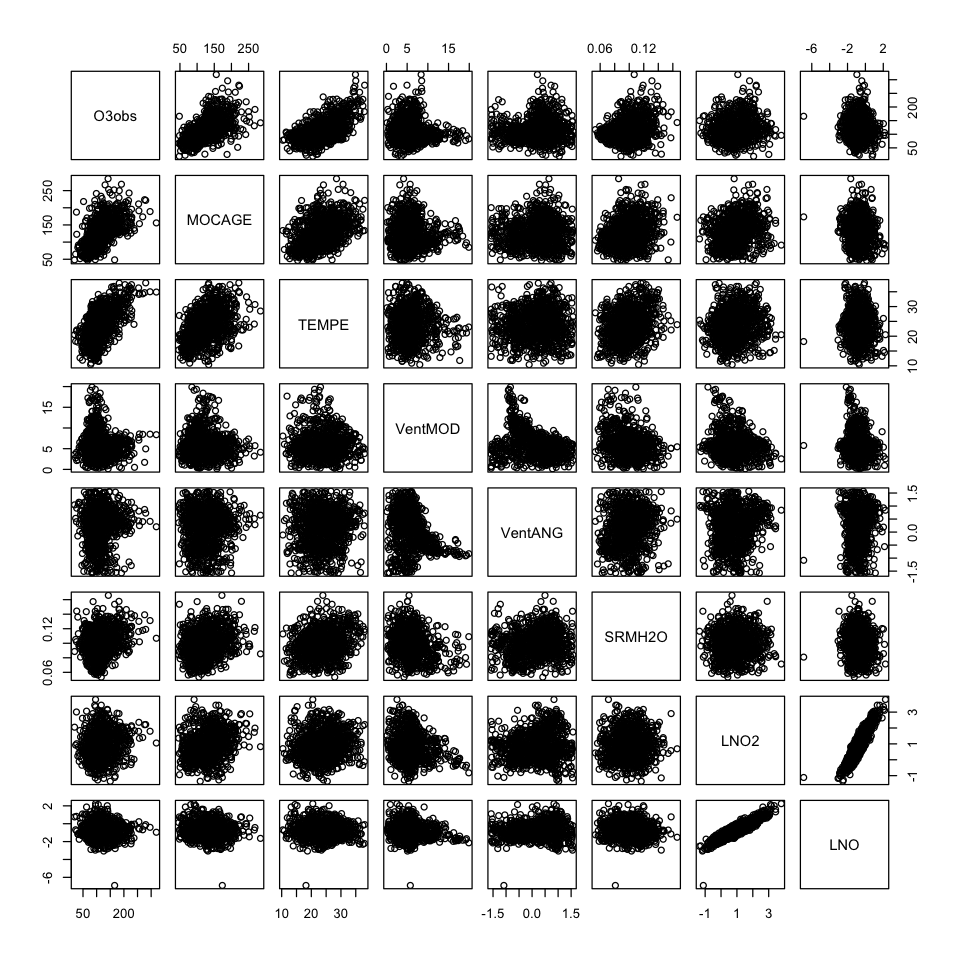

In [27]:
options(repr.plot.width=8, repr.plot.height=8)
pairs(ozone[,c(2,3,4,6:10)])

## 2. Protocole de comparaison

### Stratégie

La recherche  d'une meilleure méthode de prévision suit le protocole suivant.

1. Etape descriptive préliminaire uni et multidimensionnelle visant à repérer les incohérences, les variables non significatives ou de distribution exotique, les individus non concernés ou atypiques... et à étudier les structures des données. Ce peut être aussi la longue étape de construction de variables, attributs ou *features* spécifiques des données. 
2. Procéder à un tirage aléatoire d'un échantillon *test* qui ne sera utilisé que lors de la *dernière étape* de comparaison des méthodes.
3. La partie restante est l'échantillon d'*apprentissage* pour l'estimation des paramètres des modèles.
4. Pour chacune des méthodes, optimiser la complexité des modèles en minimisant une estimation "sans biais" de l'erreur de prévision, par exemple par [*validation croisée*](http://wikistat.fr/pdf/st-m-app-risque-estim.pdf):
    - Variables et interactions à prendre en compte dans la régression linéaire ou logistique;
    - variables et méthode pour l'analyse discriminante;
    - nombre de feuilles dans l'arbre de régression ou de classification;
    - architecture (nombre de neurones, pénalisation) du perceptron;
    - algorithme d'agrégation, 
    - noyau et pénalisation des SVMs.
5.  Comparaison des qualités de prévision sur la base du taux de mal classés pour le seul échantillon test qui est resté à l'écart de tout effort ou "acharnement" pour l'optimisation des modèles.

**Remarques**
* En cas d'échantillon relativement "petit" il est recommandé d'itérer la procédure de découpage apprentissage / test, afin de réduire la variance (moyenne) des estimations des erreurs de prévision.
* **Q** Comment appelle-t-on cette procédure spécifique de validation croisée?
* *Attention*: ne pas "tricher" en modifiant le modèle obtenu lors de l'étape précédente afin d'améliorer le résultat sur l'échantillon test!
* Le critère utilisé dépend du problème : erreur quadratique, taux de mauvais classement, entropie, AUC (aire sous la courbe ROC), indice de Pierce, *log loss function*...

### Extraction des échantillons

Les commandes ci-dessous réalisent l'extraction du sous-ensemble des données d'apprentissage et de test. 

Utiliser trois chiffres au hasard, et **remplacer** "111" ci-dessous, comme initialisation du générateur de nombres aléatoires. Attention, chaque participant tire un échantillon différent ; il est donc "normal" de na pas obtenir les mêmes modèles, les mêmes résultats.

In [8]:
set.seed(111) # initialisation du générateur
# Extraction des échantillons
test.ratio=.2   # part de l'échantillon test
npop=nrow(ozone) # nombre de lignes dans les données
nvar=ncol(ozone) # nombre de colonnes
# taille de l'échantillon test
ntest=ceiling(npop*test.ratio)
# indices de l'échantillon test
testi=sample(1:npop, ntest)
# indices de l'échantillon d'apprentissage
appri=setdiff(1:npop, testi)

Construction des échantillons pour la régression: prévision de la concentration en ozone.

In [9]:
# construction de l'échantillon d'apprentissage
datappr=ozone[appri,-11] 
# construction de l'échantillon test
datestr=ozone[testi,-11] 
summary(datappr) # vérification

 JOUR        O3obs           MOCAGE          TEMPE         STATION         
 0:581   Min.   : 19.0   Min.   : 46.4   Min.   :10.40   Length:832        
 1:251   1st Qu.: 88.0   1st Qu.: 98.0   1st Qu.:20.27   Class :character  
         Median :110.0   Median :125.9   Median :23.90   Mode  :character  
         Mean   :115.8   Mean   :127.7   Mean   :23.94                     
         3rd Qu.:135.0   3rd Qu.:154.9   3rd Qu.:27.60                     
         Max.   :319.0   Max.   :268.6   Max.   :38.00                     
    VentMOD           VentANG            SRMH2O             LNO2        
 Min.   : 0.1414   Min.   :-1.5708   Min.   :0.05339   Min.   :-1.3548  
 1st Qu.: 3.9825   1st Qu.:-0.3940   1st Qu.:0.08813   1st Qu.: 0.2042  
 Median : 5.5938   Median : 0.3019   Median :0.09932   Median : 0.7405  
 Mean   : 5.9413   Mean   : 0.1687   Mean   :0.09967   Mean   : 0.8458  
 3rd Qu.: 7.1694   3rd Qu.: 0.6875   3rd Qu.:0.11155   3rd Qu.: 1.4301  
 Max.   :19.8910   Max.   : 1.

Construction des échantillons pour la discrimination: prévision de dépassement.

In [20]:
ozone

JOUR,O3obs,MOCAGE,TEMPE,STATION,VentMOD,VentANG,SRMH2O,LNO2,LNO,DepSeuil
<fct>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,91,93.2,21.5,Aix,9.5000,-0.64350,0.09203260,0.4712528,-0.858021824,FALSE
1,100,104.6,20.2,Aix,8.0100,-0.04996,0.09386160,0.7518877,-0.632993258,FALSE
0,82,103.6,17.4,Aix,9.3771,-0.12832,0.09751923,0.5050087,-0.761426021,FALSE
0,94,94.8,18.8,Aix,9.4578,-0.34516,0.09246621,0.8544153,-0.355247392,FALSE
0,107,99.0,23.7,Aix,7.8791,-0.41822,0.08549854,0.5025918,-0.794073099,FALSE
0,150,114.3,23.6,Aix,6.3127,0.06341,0.10871982,1.6707211,0.294905918,FALSE
0,164,127.7,26.6,Aix,4.8042,0.04164,0.09679876,1.0441561,-0.597837001,TRUE
1,135,164.3,23.5,Aix,4.8795,0.79989,0.10425929,2.7557604,1.068496665,FALSE
1,121,144.1,23.3,Aix,5.1088,0.70226,0.10807405,2.1755469,0.624332865,FALSE


In [10]:
# construction de l'échantillon d'apprentissage
datappq=ozone[appri,-2]
# construction de l'échantillon test 
datestq=ozone[testi,-2] 
summary(datappq) # vérification

 JOUR        MOCAGE          TEMPE         STATION             VentMOD       
 0:581   Min.   : 46.4   Min.   :10.40   Length:832         Min.   : 0.1414  
 1:251   1st Qu.: 98.0   1st Qu.:20.27   Class :character   1st Qu.: 3.9825  
         Median :125.9   Median :23.90   Mode  :character   Median : 5.5938  
         Mean   :127.7   Mean   :23.94                      Mean   : 5.9413  
         3rd Qu.:154.9   3rd Qu.:27.60                      3rd Qu.: 7.1694  
         Max.   :268.6   Max.   :38.00                      Max.   :19.8910  
    VentANG            SRMH2O             LNO2              LNO         
 Min.   :-1.5708   Min.   :0.05339   Min.   :-1.3548   Min.   :-6.9078  
 1st Qu.:-0.3940   1st Qu.:0.08813   1st Qu.: 0.2042   1st Qu.:-1.4610  
 Median : 0.3019   Median :0.09932   Median : 0.7405   Median :-0.9455  
 Mean   : 0.1687   Mean   :0.09967   Mean   : 0.8458   Mean   :-0.8418  
 3rd Qu.: 0.6875   3rd Qu.:0.11155   3rd Qu.: 1.4301   3rd Qu.:-0.2884  
 Max.   : 1.5708

## 3. Arbres de décision

La librairie rpart est celle la plus couramment utilisée pour la construction d'arbres de décision. Deux types d'arbre peuvent être estimer selon que la variable à modéliser est la concentration d'ozone (arbre de régression) ou directement le dépassement du seuil (arbre de discrimination ou de décision). Différents paramètres contrôlent l'exécution de l'algorithme: la pénalisation minimale (cp) pour la construction de l'arbre maximal, le nombre minimal d'observation par noeud, le nombre de validations croisées (par défaut 10)... cf. l'aide en ligne (?rpart.control) pour plus de détails mais celle-ci n'est pas très explicite sur certains paramètres, c'est le travers des logiciels "libres".

NB. Une séquence de valeurs de la pénalisation cp est associée à une séquence d'arbres emboîtés.


In [11]:
?rpart.control

No documentation for ‘rpart.control’ in specified packages and libraries:
you could try ‘??rpart.control’

### Estimation et élagage de l'arbre de régression
**Q** Quel critère est optimisé lors de la création d'un noeud? de l'arbre?

Lors de la création d'un nouveau noeud la métrique optimisé est le SST (l'entropie de Shannon ou le Gini pour les classification) par exemple

$$R(T) = S_{T}=\sum\left(y_{i}-\bar{y}\right)^{2}$$


On utilise une valeur de CP (pénalisation de paramêtres) par default, cependant il faudra trouver une meilleurs valeur pour ce paramêtre (car notre arbres est trop grands / il overfit). Ducoup on effectue un 10-fold pour optimiser cette valeur sur des données de tests.

Le formule du CP est la suivante:

$$\underbrace{R_{\alpha}(T)}_{ScoreCP}= \underbrace{R(T)}_{Score}+ \underbrace{\alpha|T|}_{Penalisation}$$

In [12]:
library(rpart) # chargement de la librairie
tree.reg <- rpart(O3obs~., data = datappr, control = rpart.control(cp = 0.001))
# La commande ci-dessous fournit un descriptif de l'arbre obtenu
# summary(tree.reg)
# mais un graphe est  préférable

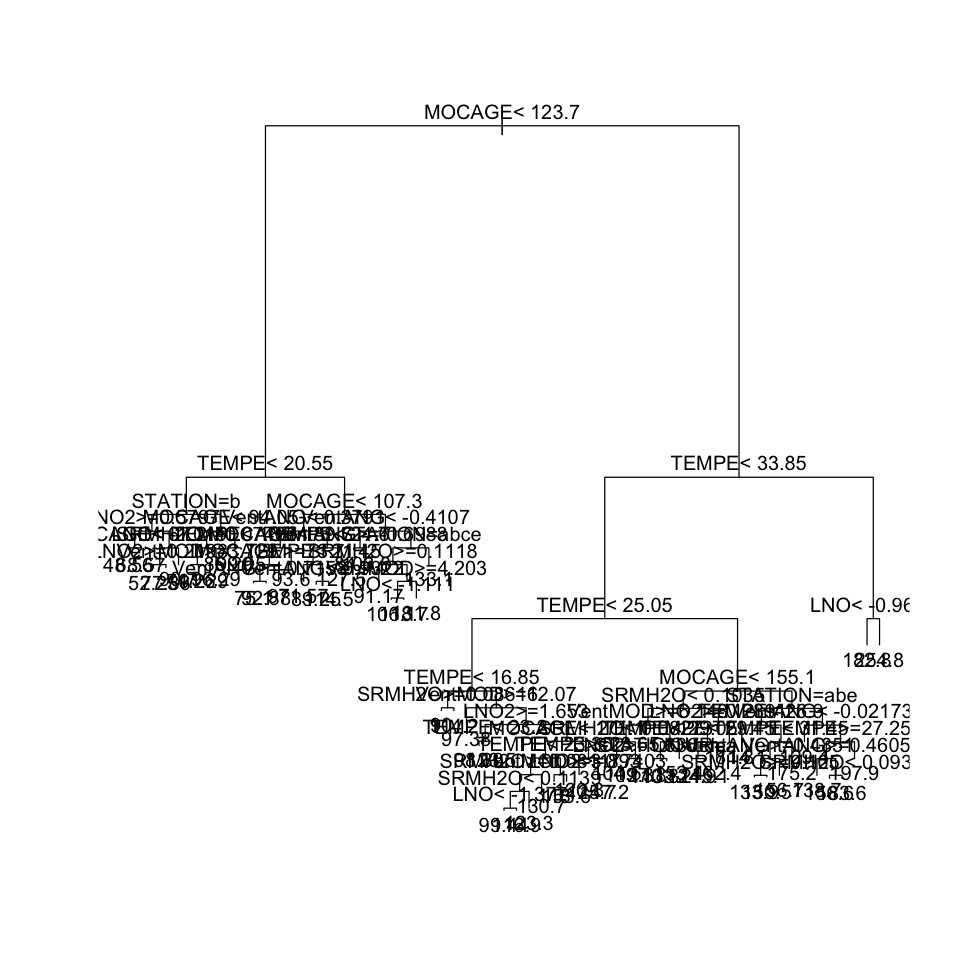

In [13]:
plot(tree.reg)
text(tree.reg)

L'arbre est illisible et présente trop de feuilles pour une bonne prévision (sur-apprentissage), il est nécessaire d'en réduire le nombre par élagage. Les commandes suivantes calculent les prévisions obtenues par  validation croisée *10-fold* pour chaque arbre élagué suivant les valeurs successives du coefficient de complexité. La séquence de ces valeurs est implicitement celle fournit par `rpart`. 

In [14]:
xmat <- xpred.rpart(tree.reg)
xerr <- (xmat - datappr[,"O3obs"])^2
CVerr <- apply(xerr, 2, sum)
CVerr  # CP erreur

0.650389937 0.190757054 0.086599002 0.044402955 0.026636689 0.018187164 
  1395921.2    992093.2    884319.5    817715.7    756610.5    740884.3 
0.013732509 0.011084622 0.008362540 0.007221621 0.006956881 0.006653914 
   733067.9    743634.4    735258.1    737612.7    747110.4    744985.3 
0.006487036 0.006270700 0.005972066 0.005319037 0.004732087 0.004557061 
   740395.1    739476.3    746622.8    752119.9    752566.9    751472.0 
0.004513292 0.004302262 0.004031475 0.003886693 0.003757776 0.003456486 
   748603.6    766116.7    753352.2    750799.6    746345.3    754933.8 
0.002930327 0.002647561 0.002567387 0.002437882 0.002374911 0.002342909 
   760775.7    773509.5    779116.9    785036.5    788692.0    788692.0 
0.002280352 0.002186360 0.002005132 0.001884622 0.001785959 0.001682822 
   791616.2    792038.9    786638.6    786983.9    788027.2    792415.6 
0.001630264 0.001587103 0.001579396 0.001451242 0.001333661 0.001326259 
   792494.9    789905.2    789905.2    791409.7    793038.2    793038.2 
0.001314821 0.001281492 0.001246655 0.001224731 0.001193056 0.001087566 
   792260.9    792602.0    794738.8    794573.8    795271.8    795302.7 
0.001004035 
   797354.2

Chercher la valeur de `cp` correspondant à la plus petite erreur puis l'utiliser pour la construction de l'arbre.

In [15]:
cpMin <- as.numeric(attributes(which.min(CVerr))$names)

In [16]:
tree.reg <- rpart(O3obs~., data = datappr, control = rpart.control(cp = cpMin))

La librairie `partykit` propose une construction graphique de l'arbre:

Le chargement a nécessité le package : grid

Le chargement a nécessité le package : libcoin

Le chargement a nécessité le package : mvtnorm



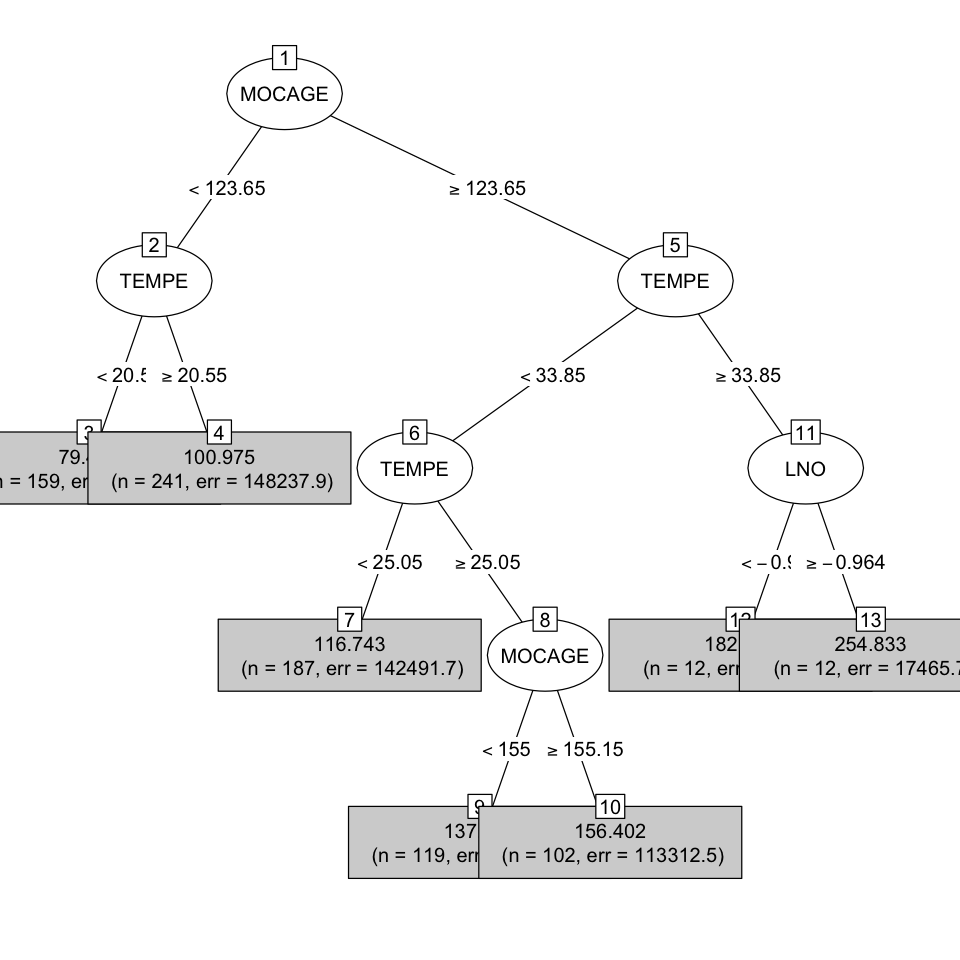

In [17]:
library(partykit)
plot(as.party(tree.reg), type = "simple")

La fenêtre est trop petite pour représenter les distributions (histogramme) de la variable cible (concentration en ozone) dans chaque feuille. 

**Q** Quelle est la variable qui contribue le plus à l'interprétation?

La variable *MOCAGE* à la plus grosse contribution pour séparés les éléments car c'est on l'utilise pour la 1er discrimination 

Graphe des résidus

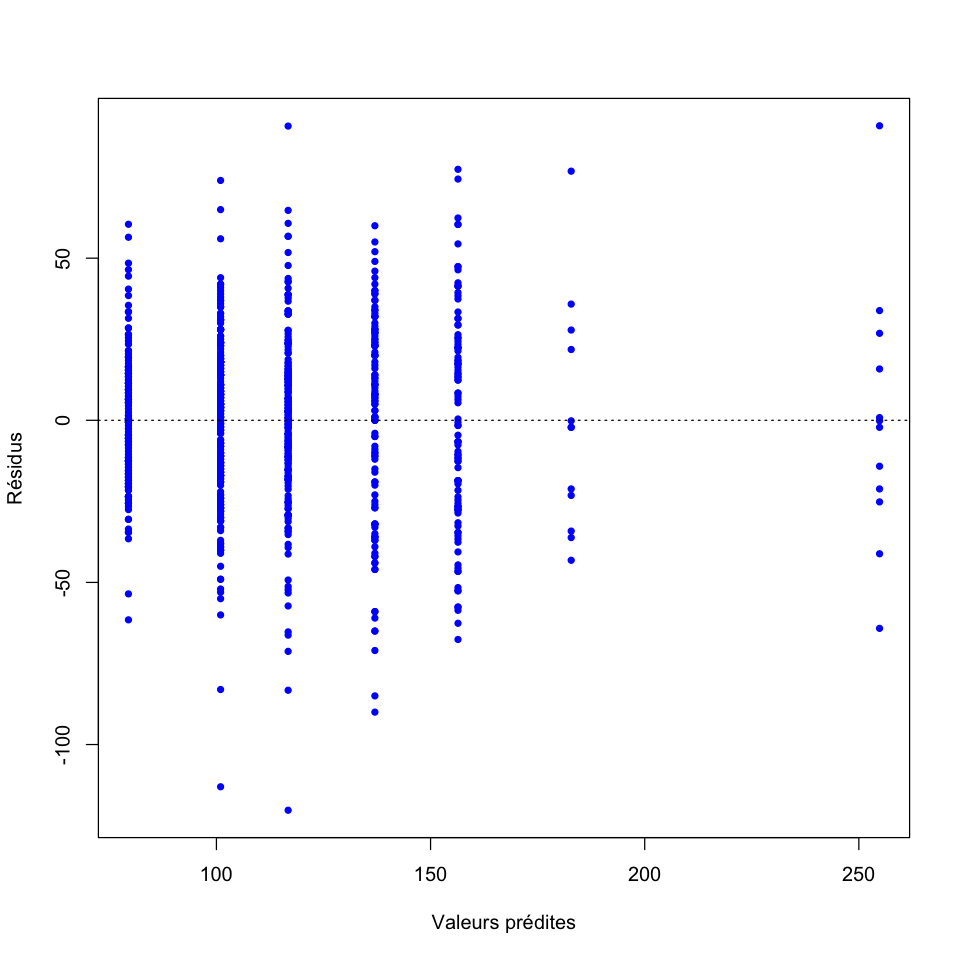

In [18]:
fit.tree <- predict(tree.reg)
res.tree <- fit.tree - datappr[, "O3obs"]
plot(fit.tree, res.tree, 
     col = "blue", pch = 20,
     ylab = "Résidus", xlab = "Valeurs prédites")
abline(h = 0, lty = "dotted")

**Q** A quoi est due la structure particulière de ce graphe?

Car les valeurs 

![Regression discrete](/Users/julienblanchon/Git/julien-blanchon/Le-TP-de-Keunotor3/analyse-donnees/tp-janvier/capture1.png)

### Estimation et élagage d'un arbre de discrimination

Dans le cas d'une discrimination, le critère par défaut est l'indice de concentration de Gini ; il est possible de préciser un autre critère (split="information") ainsi que des poids sur les observations, une matrice de coûts de mauvais classement ainsi que des probabilités *a priori* (?rpart pour plus de détails).

**Q** En lisant la vignette "longintro" du package RPart, expliquer le lien entre le critère d'"information" et le critère d'entropie vu en cours.

`information` == `entropie`

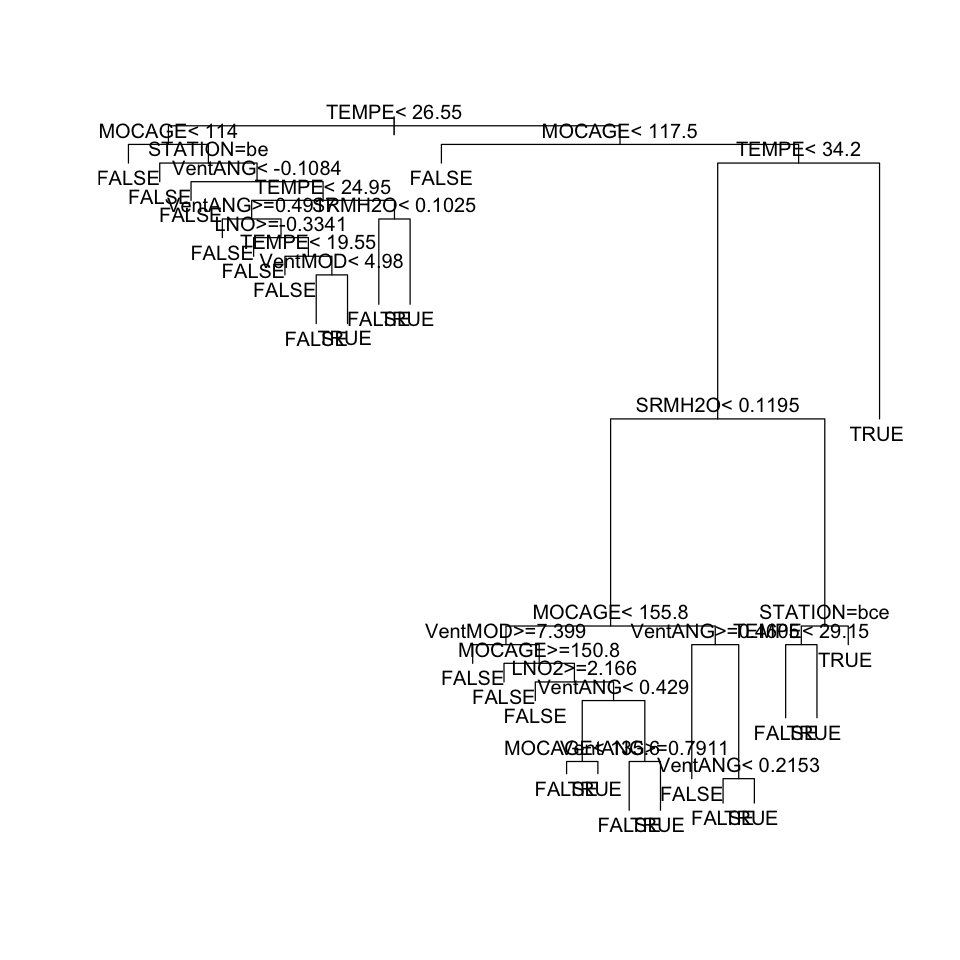

In [56]:
tree.dis <- rpart(DepSeuil~., data = datappq, 
                  parms = list(split = "information"), cp = 0.001)
plot(tree.dis)
text(tree.dis)

La même procédure d'élagage par validation croisée est mise en place mais avec un expression différente de l'erreur de prévision: taux de mal classés plutôt qu'erreur quadratique.

In [43]:
xmat <- xpred.rpart(tree.dis)
# Comparaison des valeurs prédite et observée
xerr <- datappq$DepSeuil != (xmat > 1.5) 
# Calcul  des estimations des taux d'erreur
CVerr <- apply(xerr, 2, sum)/nrow(xerr)
CVerr

0.525925926 0.045961754 0.030089031 0.018144368 0.012394963 0.009799079 
  0.1622596   0.1430288   0.1430288   0.1598558   0.1502404   0.1574519 
0.008281733 0.002721655 
  0.1622596   0.1634615

In [44]:
cpMin <- as.numeric(attributes(which.min(CVerr))$names)
cpMin

[1] 0.04596175

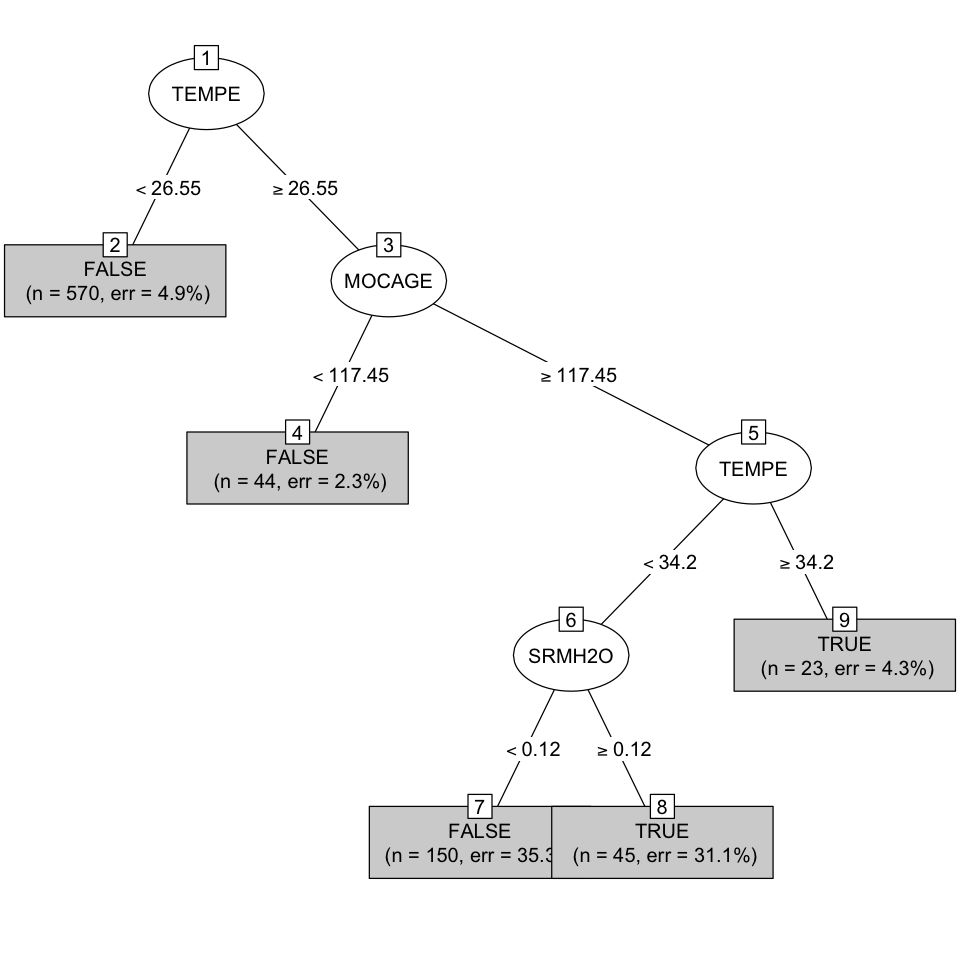

In [45]:
tree.dis <- rpart(DepSeuil~., data = datappq, parms = list(split = "information"), cp = cpMin)
plot(as.party(tree.dis), type="simple")

### Prévision de l'échantillon test

Différentes prévisions sont considérées assorties des erreurs estimées sur l'échantillon test. Prévision quantitative de la concentration, prévision de dépassement à partir de la prévision quantitative et directement la prévision de dépassement à partir de l'arbre de décision. 

In [52]:
# Calcul des prévisions
pred.treer <- predict(tree.reg, newdata = datestr)
pred.treeq <- predict(tree.dis, newdata = datestq, type = "class")
# Erreur quadratique moyenne de prévision en régression
sum((pred.treer - datestr[, "O3obs"])^2) / nrow(datestr)

[1] 749.0224

In [50]:
# Matrice de confusion pour la prévision du
# dépassement de seuil (régression)
table(pred.treer > 150, datestr[, "O3obs"] > 150)

       
        FALSE TRUE
  FALSE   159   17
  TRUE      7   26

In [51]:
# Même chose pour l'arbre de discrimination
table(pred.treeq, datestq[, "DepSeuil"])

          
pred.treeq FALSE TRUE
     FALSE   165   28
     TRUE      1   15

**Q** Quelle stratégie semble meilleure à ce niveau?

Cela dépend de de notre critère, est il pire d'avoir des faux négatif ou des faux positif ?

De facon général, l'arbre de distrimination fait beaucoup plus d'erreur que la prévision du dépassement de seuil (régression).

## [Agrégation de modèles](http://wikistat.fr/pdf/st-m-app-agreg.pdf)

### Introduction

Les sections précédentes ont permis d'expérimenter les constructions d'un modèle de prévision assorties du problème récurrent lié à l'optimisation de la complexité d'un modèle. Cette section aborde d'autres stratégies dont l'objectif est de s'affranchir de ce problème de choix, par des méthodes se montrant pas ou très peu sensibles au sur-apprentissage ; c'est le cas des algorithmes d'agrégation de modèles.

Cette section propose de mettre en évidence la plus ou moins grande influence des paramètres de ces méthodes. 
* *Random forest*: nombre d'arbres et `mtry` et intérêt des critères de Breiman permettant de mesurer l'influence des variables au sein d'une famille agrégée de modèles. 
* Le *bagging*, cas particulier de forêt aléatoire, n'est pas traité;

**Q** Quel est le paramètre `mtry` de la fonction `randomForest`?



**Q** En quoi le bagging est un cas particulier des forêts aléatoires?

### Forêts aléatoires

Le programme est disponible dans la librairie *randomForest*. Il est écrit en fortran, donc en principe efficace en terme de rapidité d'exécution, et facile à utiliser grâce à une interface avec R. La comparaison avec Python montre qu'il n'est finalement pas très efficace sans doute à cause de l'interface avec R. Les paramètres et sorties sont explicités dans l'aide en ligne.

En R et pour des gros fichiers, privilégier la librairie `ranger` à la place de `ranfomForest`. 

#### Régression

In [61]:
library(randomForest)
rf.reg <- randomForest(O3obs~., data=datappr, xtest=datestr[,-2],ytest=datestr[,"O3obs"],
   ntree=500,do.trace=50,importance=TRUE)

     |      Out-of-bag   |       Test set    |
Tree |      MSE  %Var(y) |      MSE  %Var(y) |
  50 |      739    44.10 |    620.1    36.68 |
 100 |    713.1    42.55 |    588.7    34.83 |
 150 |    705.8    42.12 |      596    35.26 |
 200 |    701.1    41.84 |      597    35.31 |
 250 |    696.7    41.57 |    598.3    35.39 |
 300 |    697.3    41.61 |    593.7    35.12 |
 350 |    694.1    41.42 |    594.7    35.18 |
 400 |    696.1    41.54 |    592.6    35.06 |
 450 |    697.3    41.61 |    589.5    34.87 |
 500 |    697.7    41.63 |    591.3    34.98 |


**Q** Quelles est la valeur par défaut de `mtry`?

D'après la doc `mtry` : 

``Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification (sqrt(p) where p is number of variables in x) and regression (p/3)``

Par défaut on a : 
``
mtry=if (!is.null(y) && !is.factor(y))
             max(floor(ncol(x)/3), 1) else floor(sqrt(ncol(x)))
``

Donc si regression (pas de $y$) $\frac{p}{3}$, si classification $\sqrt{p}$ avec p le nombre de variables dans x.

Relancer en faisant varier les paramètres `mtry` et `ntree` pour expérimenter leur peu d'influence sur les erreurs.

Calcul et graphe des résidus.

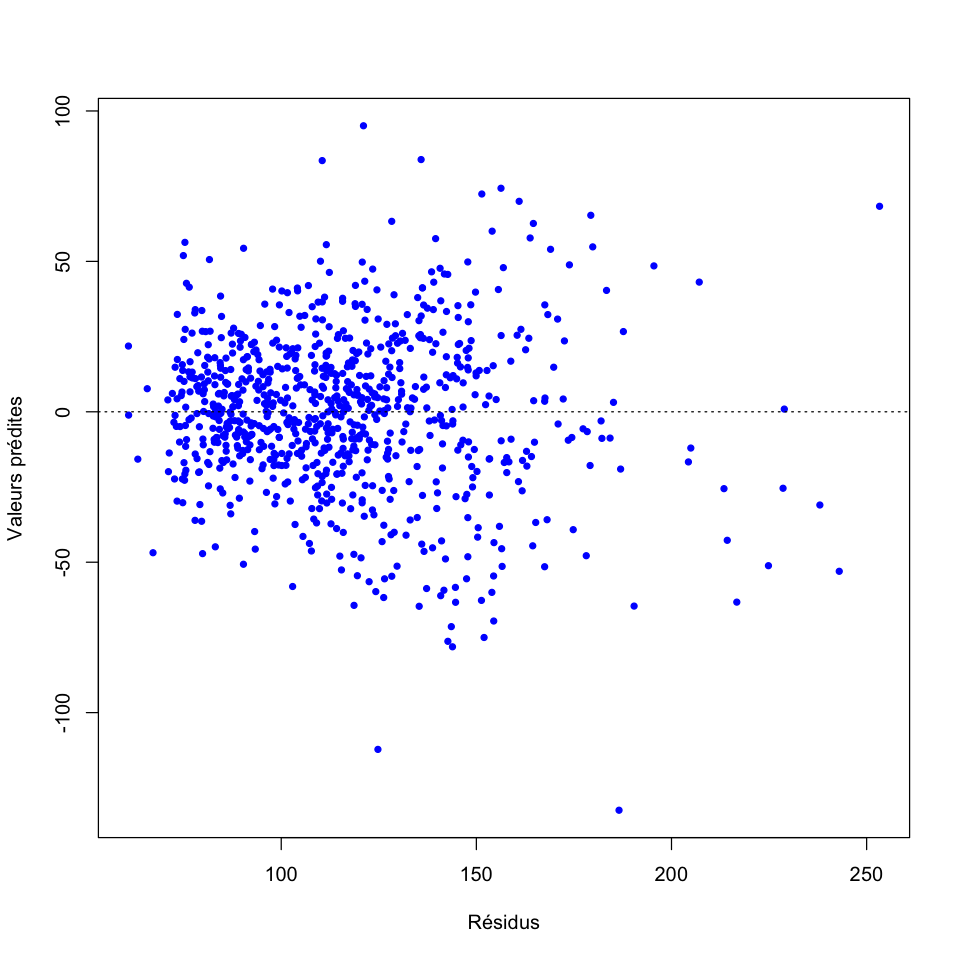

In [60]:
fit.rfr <- rf.reg$predicted
res.rfr <- fit.rfr - datappr[,"O3obs"]
plot(fit.rfr, res.rfr, 
     col = "blue", pch = 20,
     xlab = "Résidus", ylab = "Valeurs prédites")
abline(h = 0, lty = "dotted")

#### Discrimination
**Q** Quelle est la valeur par défaut de `mtry`?

In [27]:
str(datestq[, "DepSeuil"])

 Factor w/ 2 levels "FALSE","TRUE": 1 1 1 1 1 2 1 1 1 2 ...


In [28]:
rf.dis <- randomForest(DepSeuil ~ ., data = datappq, 
                       xtest = datestq[, -10], ytest = datestq[, "DepSeuil"],
                       ntree = 500, do.trace = 50, importance = TRUE)

ntree      OOB      1      2|    Test      1      2
   50:  11.78%  4.02% 51.85%|  11.00%  1.20% 48.84%
  100:  10.94%  3.59% 48.89%|  11.96%  1.20% 53.49%
  150:  11.54%  3.87% 51.11%|  11.48%  1.20% 51.16%
  200:  11.54%  3.73% 51.85%|  11.48%  1.20% 51.16%
  250:  11.66%  3.73% 52.59%|  11.48%  1.20% 51.16%
  300:  11.42%  3.59% 51.85%|  11.48%  1.20% 51.16%
  350:  11.30%  3.30% 52.59%|  11.96%  1.20% 53.49%
  400:  11.42%  3.59% 51.85%|  11.48%  1.20% 51.16%
  450:  11.30%  3.59% 51.11%|  11.48%  1.20% 51.16%
  500:  11.30%  3.59% 51.11%|  11.48%  1.20% 51.16%


Commenter les erreurs, tester d'autres exécutions avec d'autres valeurs des paramètres.

#### Prévision de l'échantillon test

In [29]:
pred.rfr <- rf.reg$test$predicted
pred.rfq <- rf.dis$test$predicted
# Erreur quadratique moyenne de prévision
sum((pred.rfr - datestr[,"O3obs"])^2) / nrow(datestr)

[1] 604.0771

In [30]:
# Matrice de confusion pour la prévision du 
# dépassement de seuil (régression)
table(pred.rfr > 150, datestr[, "O3obs"] > 150)

       
        FALSE TRUE
  FALSE   163   19
  TRUE      3   24

In [31]:
# Même chose pour la discrimination
table(pred.rfq, datestq[,"DepSeuil"])

        
pred.rfq FALSE TRUE
   FALSE   164   22
   TRUE      2   21

#### Importance des variables

Le modèle obtenu est ininterprétable mais des coefficients estiment les contributions des variables dans leur participation à la discrimination. Comparer avec les variables sélectionnées par les autres modèles. deux critères d'importance sont proposés.

**Q** Quelles sont les deux mesures d'importance des variables?

In [32]:
sort(round(importance(rf.reg), 2)[,1], decreasing=TRUE)
sort(round(importance(rf.dis), 2)[,4], decreasing=TRUE)

TEMPE  MOCAGE VentANG    LNO2 STATION     LNO VentMOD  SRMH2O    JOUR 
  48.73   45.58   16.56   14.60   13.82   13.55   12.13   12.01   -1.16

TEMPE  MOCAGE VentANG  SRMH2O VentMOD    LNO2     LNO STATION    JOUR 
  66.84   41.54   26.56   25.70   19.78   18.43   18.27    7.09    2.17

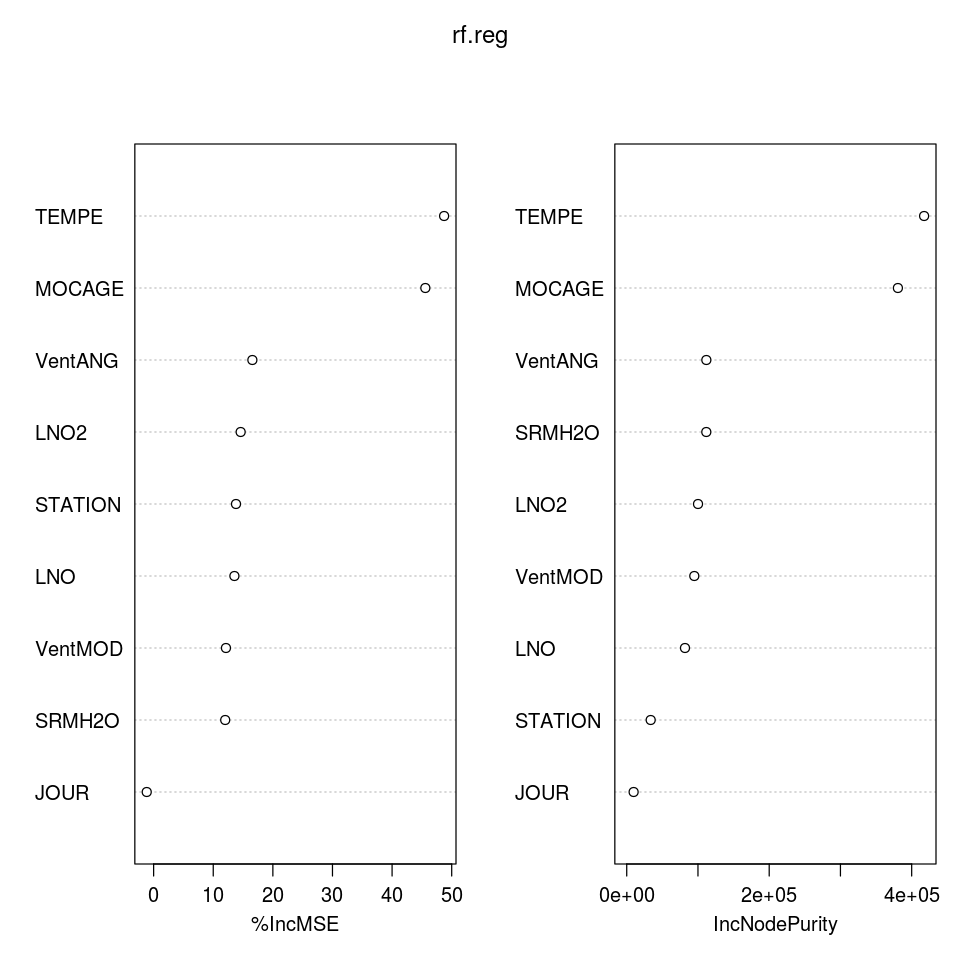

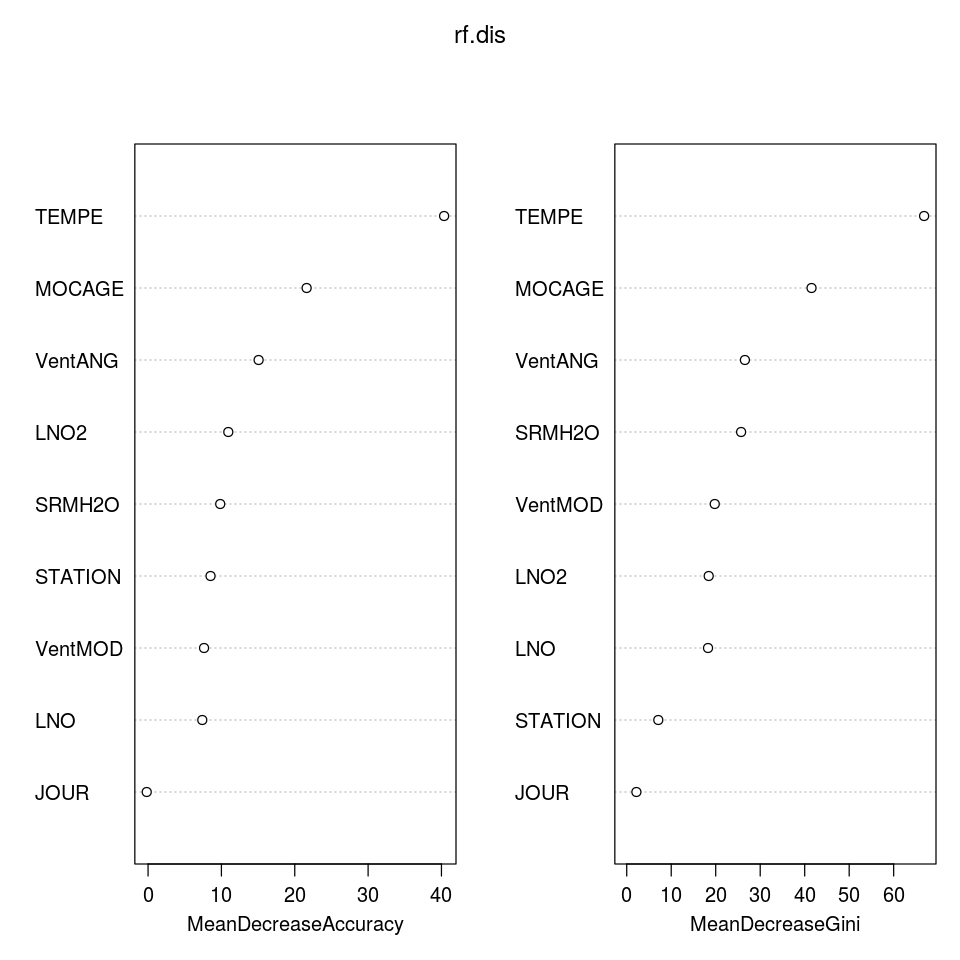

In [33]:
varImpPlot(rf.reg)
varImpPlot(rf.dis)

### Réglage du paramètre `mtry` 

La libraire caret permet d'estimer des paramètres d'algorithme par validation croisée. En particulier, pour les forêts aléatoires, le paramètre  `mtry`.

In [34]:
library(caret)
cvControl <- trainControl(method = "cv", number = 10)
rfFit <- train(datappq[, -10], datappq[, 10], method = "rf", tuneLength = 8,
               trControl = cvControl, trace = FALSE)

Loading required package: lattice

Loading required package: ggplot2

Warning message:
“package ‘ggplot2’ was built under R version 4.1.0”

Attaching package: ‘ggplot2’


The following object is masked from ‘package:randomForest’:

    margin




Random Forest 

832 samples
  9 predictor
  2 classes: 'FALSE', 'TRUE' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 749, 749, 749, 748, 750, 748, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
  2     0.8809912  0.4719615
  3     0.8737473  0.4645448
  4     0.8785522  0.4777732
  5     0.8749374  0.4711383
  6     0.8785812  0.4790387
  7     0.8773911  0.4749045
  8     0.8713520  0.4570061
  9     0.8725568  0.4607891

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 2.

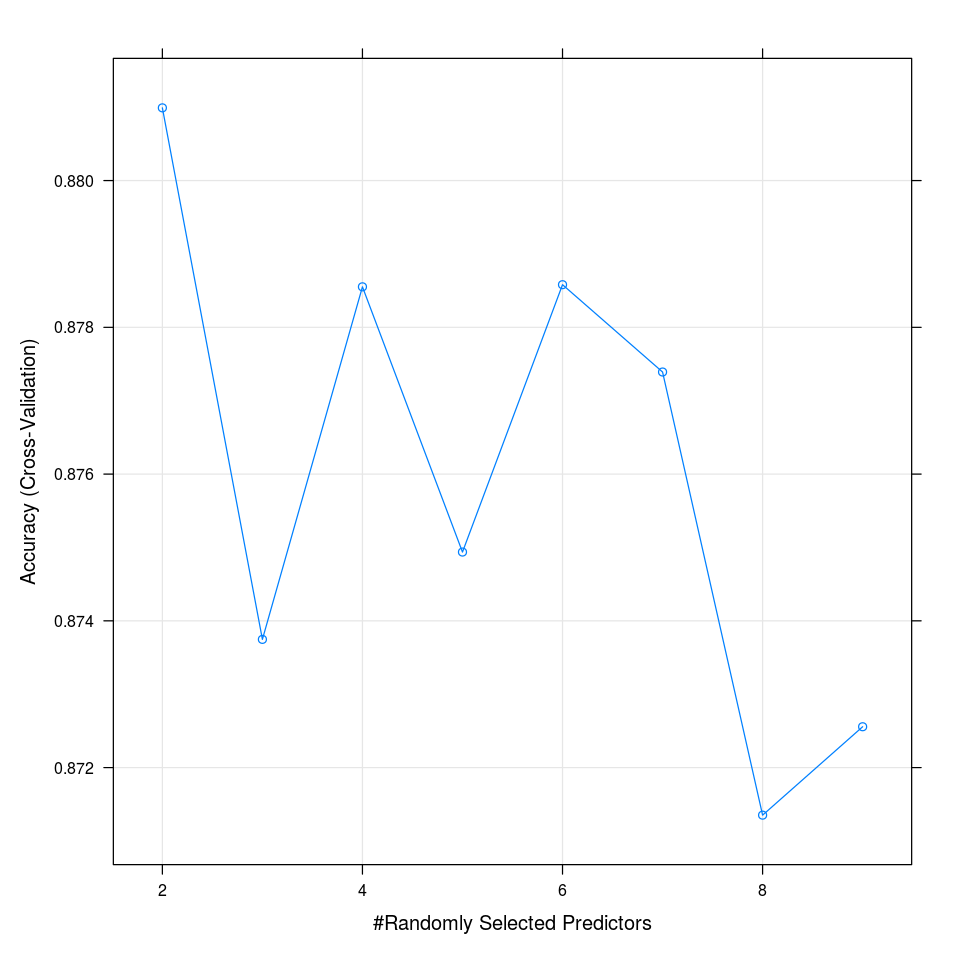

In [35]:
rfFit
plot(rfFit)

** Q ** Comparer avec la valeur par défaut de `mtry`. Si elle est différente, que faire ?